In [1]:
from func.load import *

load = Load('dataset_test')
df = pd.concat([d for d in load], ignore_index=True)
locations = [[lat, lng] for [days, lat, lng] in df.values]
print(df.head(3))

       days        lat         lng
0  0.000000  39.921892  116.156125
1  0.000278  39.921898  116.156369
2  0.000556  39.921904  116.156612


In [2]:
import folium
from folium.plugins import HeatMap
import json

locations = [[lat, lng] for [days, lat, lng] in df.values]

m = folium.Map(location=locations[0], zoom_start=16)
HeatMap(locations).add_to(m)
folium.PolyLine(locations).add_to(m)

m.save('map/df_test.html')


In [3]:
from func.extraction import StayPoint

extraction = StayPoint(df, roh=0.3, phi=5)
sp = extraction.ex_sp()

import folium
from folium.plugins import HeatMap
import json

m = folium.Map(location=locations[0], zoom_start=16)
HeatMap(locations).add_to(m)
m.save('map/test_sp.html')

计算cohs: 0,
聚类求簇
求驻足点


In [4]:
from func.extraction import landmark
lm = landmark(sp, eps=8, minPts=1)

m = folium.Map(location=locations[0], zoom_start=13)
HeatMap(locations).add_to(m)
for p in lm:
    folium.Marker(p).add_to(m)
m.save('map/test_lm.html')

开始求landmark
正在求中心点


In [47]:
from func.serialization import serial
import folium
from itertools import islice
import numpy as np
from func.predication import *
input_n = 7
output_n = 1

ss = serial('dataset/001', 'results/landmarks.json', 0.1)

# ss = islice(ss, 2)
for df, se in ss:
    data = np.array(se)
    # print(data.shape)

    if len(data) <= input_n*2:
        # print('Inefficent Number of samples: '+str(len(data)))
        continue

    else:
        print(len(data))
        data, normalize = NormalizeMult(data, set_range=True)
        np.savetxt('model/normalize.txt', normalize)

        train_X, train_Y, test_X, test_Y = create_dataset(data, input_n, output_n)
        # print(train_X)

        model = trainModel(train_X, train_Y)
        loss, acc = model.evaluate(train_X, train_Y, verbose=2)
        print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))

        # break

model.save('model/track_model.h5')


21
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.1396 - acc: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1166 - acc: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0907 - acc: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0804 - acc: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0714 - acc: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0684 - acc: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0745 - acc: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.0641 - acc: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0679 - acc: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0603 - acc: 1.0000
Epoch 11/100
1/1 [==============================] - 0s 9ms/step - loss

In [6]:
from func.serialization import serial
import folium
from itertools import islice
import numpy as np
from func.predication import *
input_n = 7
output_n = 1

ss = serial('dataset/001', 'results/landmarks.json', 0.1)
result = []

for df, se in ss:
    data = np.array(se)
    if len(data) <= 14:
        # l.info('Inefficent Number of samples: '+str(len(data)))
        continue

    # l.info('Number of samples: '+str(len(data)))
    # l.info('Dimension of samples: '+str(len(data)))
    # l.debug(data)

    # 归一化
    data, normalize = NormalizeMult(data, set_range=True)
    np.savetxt('model/normalize.txt', normalize)

    # 选取倒数-14到-7作为测试数据
    data = data[-2 * (input_n + output_n)+1:-1 * (input_n + output_n)+1]
    data.dtype = 'float64'
    y = data[-output_n:, :]

    # 归一化数据
    x = data[:-output_n, :]
    normalize = np.loadtxt('model/normalize.txt')
    x = NormalizeMultUseData(x, normalize)

    # 使用训练好的模型进行预测
    model = load_model('model/track_model.h5')
    test_X = x.reshape(1, x.shape[0], x.shape[1])
    y_hat = model.predict(test_X)
    y_hat = y_hat.reshape(y_hat.shape[1])
    y_hat = reshape_y_hat(y_hat, 2)

    # 反归一化
    y_hat = FNormalizeMult(y_hat, normalize)
    y = FNormalizeMult(y, normalize)
    print("predict: {0}\ntrue：{1}".format(y_hat, y))
    print('预测均方误差：', mse(y_hat, y))
    print('预测直线距离：{:.4f} KM'.format(haversine([y_hat[0, 0], y_hat[0, 1]], [y[0, 0], y[0, 1]])))

    result.append({'raw': df,
                   'seq': se[-2 * (input_n + output_n)+1:-1 * (input_n + output_n)+1],
                   'pre': y,
                   'dis': haversine([y_hat[0, 0], y_hat[0, 1]], [y[0, 0], y[0, 1]])})


listlow, listhigh, delta 39.979625 40.016599 0.03697400000000073
listlow, listhigh, delta 116.306755 116.327577 0.020822000000009666
listlow, listhigh, delta 39.979625 40.016599 0.03697400000000073
listlow, listhigh, delta 116.306755 116.327577 0.020822000000009666
predict: [[ 39.979625 116.306755]]
true：[[ 40.004919 116.319666]]
预测均方误差： 0.00040324017850009304
预测直线距离：3.0200 KM
listlow, listhigh, delta 39.978569 40.013892 0.03532299999999822
listlow, listhigh, delta 116.306755 116.328482 0.021726999999998498
listlow, listhigh, delta 39.978569 40.013892 0.03532299999999822
listlow, listhigh, delta 116.306755 116.328482 0.021726999999998498
predict: [[ 39.978569 116.306755]]
true：[[ 39.97959  116.314112]]
预测均方误差： 2.7583944999993785e-05
预测直线距离：0.6371 KM
listlow, listhigh, delta 39.988655 40.016599 0.02794399999999797
listlow, listhigh, delta 116.145281 116.312559 0.16727799999999604
listlow, listhigh, delta 39.988655 40.016599 0.02794399999999797
listlow, listhigh, delta 116.145281 116.312

In [2]:
for li in result:
    print(li)
    break

{'raw': [[39.984198, 116.319322], [39.984611, 116.319822], [39.984252, 116.320826], [39.983916, 116.32098], [39.982688, 116.321225], [39.981441, 116.321305], [39.980291, 116.32143], [39.979675, 116.321805], [39.979546, 116.322926], [39.979758, 116.324513], [39.979674, 116.326093], [39.979034, 116.32722], [39.97803, 116.327481], [39.978093, 116.327214], [39.979017, 116.327211], [39.979973, 116.327109], [39.981473, 116.326765], [39.983115, 116.326693], [39.984354, 116.326715], [39.985645, 116.326589], [39.98685, 116.3265], [39.98813, 116.326492], [39.989329, 116.326511], [39.990497, 116.32642], [39.991185, 116.326337], [39.991873, 116.32641], [39.993013, 116.326371], [39.994174, 116.326612], [39.995183, 116.32649], [39.996175, 116.326658], [39.997412, 116.326632], [39.998924, 116.326603], [39.99985, 116.325819], [39.999815, 116.324254], [39.999831, 116.322563], [40.000767, 116.321822], [40.002056, 116.3216], [40.003314, 116.3215], [40.004571, 116.32134], [40.004861, 116.31985], [40.00492

In [22]:
import folium
from folium.plugins import HeatMap
import json


m = folium.Map(location=result[0]['raw'][0], zoom_start=13)
index=10
for li in result[index:index+1]:
    folium.PolyLine(li['raw']).add_to(m)
    for p in li['seq']:
        folium.Marker(p,
                      icon=folium.Icon(color="green"),
                      tooltip="Click me!",
                      popup="<i>real point</i>").add_to(m)
    p_pre = li['pre'].tolist()[0]
    folium.Marker(p_pre,
                  icon=folium.Icon(color="red"),
                  popup='"<i>lat:'+str(p_pre[0])+',lng:'+str(p_pre[1])+',distance:'+str(li['dis'])+'km</i>', tooltip="Click me!").add_to(m)
m.save('map/predication.html')


Text(0.5, 1.0, 'Distribution of distance error')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


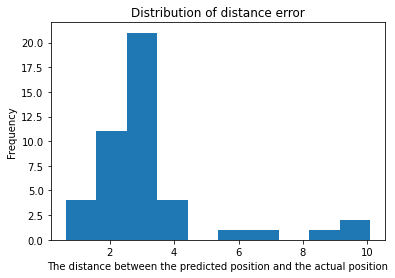

In [30]:
import matplotlib.pyplot as plt
import matplotlib
diss=[]
for li in result:
    diss.append(li['dis'])

plt.hist(diss)
plt.xlabel('The distance between the predicted position and the actual position')
plt.ylabel('Frequency')
plt.title('Distribution of distance error')


In [26]:
len(diss)


45

In [ ]:
import os

import pandas as pd
import json

import werkzeug
werkzeug.cached_property = werkzeug.utils.cached_property
import flask.scaffold
flask.helpers._endpoint_from_view_func = flask.scaffold._endpoint_from_view_func
from gevent.pywsgi import WSGIServer
from flask_restplus import Api, Resource, Namespace
from flask import Flask, request, jsonify

from func.load import Load
from func.serialization import serial
from func.predication import *